# Game of Sets - largest card deck with no matches

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Function definitions
make_card_names
make_card_deck
is_set


In [4]:
# make_card_names function initializes card_names df with names and attributes
def make_card_names():
    card_names = pd.DataFrame(columns=['color', 'shape', 'fill', 'number'])
    card_names['color'] = ['red', 'green', 'purple']
    card_names['shape'] = ['oval', 'diamond', 'squiggle']
    card_names['fill'] = ['solid', 'striped', 'empty']
    card_names['number'] = [1, 2, 3]
    return card_names

In [203]:
# make_full_deck function prepopulates complete card_deck df with all possible combinations using numbers 0, 1, 2 for each of four attributes (n=81)
def make_full_deck():
    card_deck = pd.DataFrame(columns=['color', 'shape', 'fill', 'number'])
    card_deck['color'] = [0] * 27 + [1] * 27 + [2] * 27
    card_deck['shape'] = ([0] * 9 + [1] * 9 + [2] * 9 ) * 3
    card_deck['fill'] =  ([0] * 3 + [1] * 3 + [2] * 3 ) * 9
    card_deck['number'] = [0, 1, 2] * 27
    return card_deck

In [204]:
# test or run make_full_deck function
card_deck = make_full_deck()
len(card_deck)

81

In [46]:
# make_third_card function creates third card to make a set
def make_third_card(card1, card2):
    # Calculate the sum of corresponding elements in card1 and card2, then take the result mod 3
    sum_mod_3 = (card1.values[0] + card2.values[0]) % 3

    # Calculate the third integer 'c' based on the formula: c = 3 - (a + b) mod 3
    c_values = 3 - sum_mod_3
    c_values[c_values == 3] = 0  # Replace 3 with 0, as 3 mod 3 is 0

    # return the resulting dataframe card3
    return pd.DataFrame([c_values], columns=card1.columns)

In [194]:
# trim_deck_fast function selects two random cards, finds the third card that would make a set and drops it from the card_deck if it is present.
# Note that not all matching sets are necessarily removed. Search is random and not exhaustive.
def trim_deck_fast(card_deck, iterations=100):
    for i in range(iterations):
        card1 = card_deck.sample(n=1)
        card2 = card_deck.sample(n=1)
        # make sure card1 and card2 are not the same card
        while card1.equals(card2):
            card2 = card_deck.sample()
        card3 = make_third_card(card1, card2)
        # print('three cards {} {} {}'.format(card1, card2, card3))
        try: 
            i = card_deck[card_deck.eq(card3.squeeze()).all(1)].index
            # if i is not empty, remove the card from the deck
            if i.empty:
                pass
                # print('No set found. Continuing...')
            else:
                # print('Found a set! Removing cards {} {}'.format(i, card_deck.loc[i]))
                card_deck = card_deck.drop(i)
        except KeyError:
            pass
    return card_deck

In [ ]:
# test or run trim_deck_fast function
print(len(card_deck))
card_deck = trim_deck_fast(card_deck, iterations=1000)
len(card_deck)

In [8]:
# LEGACY is_set function takes in three cards and returns True if they are a set, False otherwise
def is_set(card1, card2, card3):
    # check if all cards are the same card
    if card1.equals(card2) and card2.equals(card3):
        return False
    # check if any two cards are the same card
    if card1.equals(card2) or card2.equals(card3) or card1.equals(card3):
        return False
    # check if any two cards are not a set
    if (card1['color'] + card2['color'] + card3['color']) % 3 != 0:
        return False
    if (card1['shape'] + card2['shape'] + card3['shape']) % 3 != 0:
        return False
    if (card1['fill'] + card2['fill'] + card3['fill']) % 3 != 0:
        return False
    if (card1['number'] + card2['number'] + card3['number']) % 3 != 0:
        return False
    # if all checks pass, return True
    return True

In [9]:
# LEGACY trim_sets function takes in a card deck and two cards selected by their index and returns a card deck with all cards making a set with those two cards removed
def trim_sets(card_deck, card1_index, card2_index):
    # check that card1_index and card2_index are in range
    if card1_index >= len(card_deck) or card2_index >= len(card_deck):
        print('Error: card index out of range')
        return card_deck
    # initialize empty list to store indices of sets
    sets = []
    # loop through all cards in deck
    for i in range(len(card_deck)):
        # check if cards are a set
        if is_set(card_deck.iloc[card1_index], card_deck.iloc[card2_index], card_deck.iloc[i]):
            # add index of set to sets list
            sets.append(i)
    # drop sets from card deck
    card_deck = card_deck.drop(sets)
    # reset index
    card_deck = card_deck.reset_index(drop=True)
    # return card deck
    return card_deck

In [271]:
# LEGACY trim_deck function takes in a card deck and uses the trim sets function to trim sets from the deck from a random starting point. Matching sets are *not* exhaustively removed.
# iterations defaults to 100, but can be changed to trim more sets
def trim_deck(card_deck, iterations=100):
    for i in range(iterations):
        # pick two random cards from the deck
        card1_index = np.random.randint(len(card_deck))
        card2_index = np.random.randint(len(card_deck))
        # trim card deck of all sets with those two cards
        card_deck = trim_sets(card_deck, card1_index, card2_index)
    return card_deck

## Main program

(array([ 1.,  3.,  0.,  8.,  0., 21., 26.,  0., 21., 20.]),
 array([10. , 10.6, 11.2, 11.8, 12.4, 13. , 13.6, 14.2, 14.8, 15.4, 16. ]),
 <BarContainer object of 10 artists>)

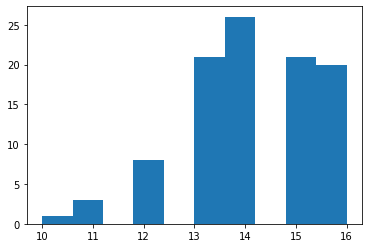

In [206]:
# trim a bunch of full card_decks and record the final lengths and resulting deck
trimmed_decks = []
trimmed_deck_lengths = []
for i in range(10000):
    # make a new deck
    card_deck = make_full_deck()
    # trim the deck
    card_deck = trim_deck_fast(card_deck, 200)
    # run again if length is more than 15, then 16
    if len(card_deck) > 15:
        card_deck = trim_deck_fast(card_deck, 1000)
    if len(card_deck) > 16:
        card_deck = trim_deck_fast(card_deck, 5000)
    # add the deck to the list of trimmed decks
    trimmed_decks.append(card_deck)
    # add the length of the deck to the list of trimmed deck lengths
    trimmed_deck_lengths.append(len(card_deck))

# plot the distribution of trimmed deck lengths
plt.hist(trimmed_deck_lengths)

In [207]:
# count the number of times each deck length appears and sort the output
trimmed_deck_lengths = pd.Series(trimmed_deck_lengths)
trimmed_deck_lengths.value_counts().sort_index()


10     1
11     3
12     8
13    21
14    26
15    21
16    20
dtype: int64

In [360]:
long_decks = []
for i in range(len(trimmed_decks)):
    if len(trimmed_decks[i]) > 16:
        long_decks.append(trimmed_decks[i])
len(long_decks)

8

In [ ]:
# loop through long_decks and apply trim_deck function to each deck
for i in range(len(long_decks)):
    long_decks[i] = trim_deck(long_decks[i], 1000)

# print the length of each deck
for i in range(len(long_decks)):
    print(len(long_decks[i]))

In [364]:
# loop through long_decks and save each deck to a csv file
for i in range(len(long_decks)):
    long_decks[i].to_csv('trimmed_deck_' + str(i) + '.csv', index=False)


In [ ]:
# print the decks from trimmed_decks with the longest length
for i in range(len(trimmed_decks)):
    if len(trimmed_decks[i]) > 16:
        print(i, trimmed_decks[i])